# ENV Set

In [373]:
import numpy as np
from scipy.io import loadmat
data = loadmat('astro_data.mat')
xx, vv = data['xx'], data['vv']

def norm(x, mean, std):
    return np.exp(-0.5 * ((x - mean) ** 2) / (std** 2)) / std

def log_pstar(state):
    log_omega, mm, pie, mu1, mu2, log_sigma1, log_sigma2 = state
    N = xx.shape[0]

    # exp process
    sigma1 = np.exp(log_sigma1)
    sigma2 = np.exp(log_sigma2)
    omega = np.exp(log_omega)
    
    x_mu = xx.mean()
    x_std = xx.std()
    ext = xx.max() - xx.min()
    
    log_ext = np.log(ext)
    
    # condition check
    forbidden_conditions = [pie < 0,
                            pie > 1,
                            np.abs(mm - x_mu) > 10 * x_std,
                            np.abs(mu1 - log_ext) > 20,
                            np.abs(mu2 - log_ext) > 20,
                            np.abs(log_sigma1) > np.log(20),
                            np.abs(log_sigma2) > np.log(20),
                            np.abs(log_omega) > 20,
                            ]
    
    if any(forbidden_conditions):
        return -np.inf
    
    log_A = 0.5 * np.log((xx - mm) ** 2 + (vv / omega) ** 2)
    
    log_prior = np.sum(np.log(pie * norm(log_A, mu1, sigma1) + (1 - pie) * norm(log_A, mu2, sigma2)))
    log_like = -2 * log_A.sum() - N * np.log(omega)
    logp = log_like + log_prior
    
    return logp


def dumb_metropolis(init, log_ptilde, iters, sigma, xx=xx, vv=vv):
    # init state
    state = init 
    Logp_state = log_ptilde(state)
    
    # init all the samples
    param_shape = init.shape[0]
    samples = np.zeros((param_shape, iters))
    
    accept = 0
    for iter in range(0, iters):
        propose_state = state + sigma * np.random.randn(len(state))
        Logp_prop = log_ptilde(propose_state)
        if (np.log(np.random.rand()) < (Logp_prop - Logp_state)).all():
            state = propose_state        # accept propose param
            Logp_state = Logp_prop       # update state
            accept += 1
        samples[:, iter] = state.squeeze()
    accept_rate = accept / iters
    return (samples, accept_rate)


In [371]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
log_omega = 1
mm = 1
pie = 1
mu1 = 1
mu2 = 1
log_sigma1 = 1
log_sigma2 = 1
# logp = log_pstar(log_omega, mm, pie, mu1, mu2, log_sigma1, log_sigma2, xx, vv)
params = np.array([log_omega, mm, pie ,mu1, mu2, log_sigma1, log_sigma2,])

# 4.1

What is the effect of Metropolis’s step-size parameter?

## step_size = 1

In [49]:
def plot_history(samples, acceptance_rate):
    params_name = ['log_omega', 'mm', 'pie', 'mu1', 'mu2', 'log_sigma1', 'log_sigma2']

    df = pd.DataFrame(samples.T, columns=params_name)
    
    df['iter'] = df.index
    lines = df.plot.line(x='iter', y=params_name)

In [50]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 1000, sigma=1)

In [51]:
acceptance_rate

0.013

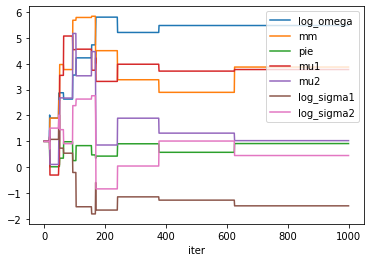

In [52]:
plot_history(samples, acceptance_rate)

## step_size = 0.01

In [53]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 1000, sigma=0.01)

In [54]:
acceptance_rate

0.777

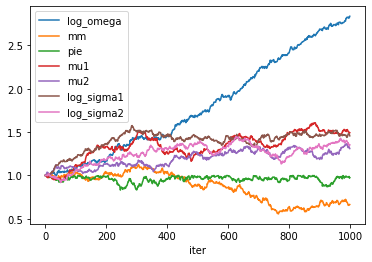

In [55]:
plot_history(samples, acceptance_rate)

## step_size = 10

In [46]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 1000, sigma=10)

In [47]:
acceptance_rate

0.0

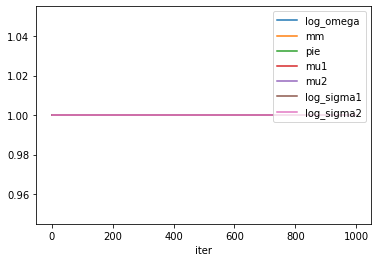

In [48]:
plot_history(samples, acceptance_rate)

- Little step size will lead to small exploration range
- Too Large step size will crash the sampling, no sample accepted
- We need a suitable step size and burn-in time

# 4.2

Is the way you initialize the chain critical for Metropolis and/or slice sampling?

We just change our init

In [63]:
log_omega = 1
mm = 1
pie = 0.1
mu1 = 1
mu2 = 10
log_sigma1 = 1
log_sigma2 = 1
# logp = log_pstar(log_omega, mm, pie, mu1, mu2, log_sigma1, log_sigma2, xx, vv)
params = np.array([log_omega, mm, pie ,mu1, mu2, log_sigma1, log_sigma2,])

In [64]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 1000, sigma=1)
acceptance_rate

0.011

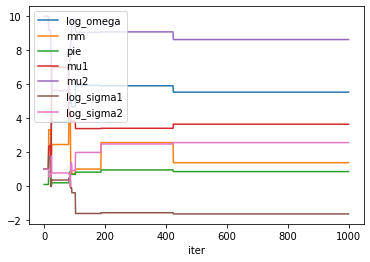

In [65]:
plot_history(samples, acceptance_rate)

In [66]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 10000, sigma=1)
acceptance_rate

0.0012

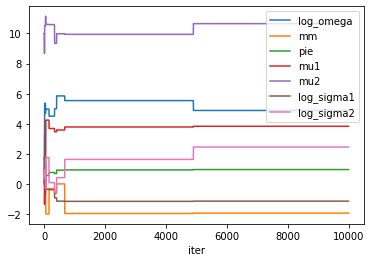

In [67]:
plot_history(samples, acceptance_rate)

We may need more burn-in time to make the sampling consistent.

# 4.3

What are the relative advantages of slice-sampling and Metropolis? Can you say good
and bad things about both of them?

### slice-sampling
pros:
slice-sampling can be more efficient for not rejecting the samples, which is suitable for the case that we do not have much information about the distribution.

cons:
slice-sampling may suffer from locality for those complicated distribuion. It is hard for slice-sampling to explore those far away high probability area across some low probability area.

### Metropolis
pros:
Metropolis is quite simple and can generally working in most cases.

cons:
As we showed above, Metropolis may rely on its hyperparameters(step-size) and have burn-in period.

# 4.4

Why have I taken logs of quantities like ω and A? Need I have bothered? Does taking
logs affect the model and/or the sampler?

Log can convert the multiply to addition, which in some sense can prevent the precision problem. The final result is not affected. (just like log likelihood)

# 4.5

The true values are ω = 875.2 and m= 31.79. Are your posterior beliefs consistent with
this? If not, what do you think went wrong with the sampling, modelling or both?

In [316]:
log_omega = 10
mm = 1
pie = 1
mu1 = 1
mu2 = 1
log_sigma1 = 0.1
log_sigma2 = 0.1
# logp = log_pstar(log_omega, mm, pie, mu1, mu2, log_sigma1, log_sigma2, xx, vv)
params = np.array([log_omega, mm, pie ,mu1, mu2, log_sigma1, log_sigma2,])

In [324]:
samples, acceptance_rate = dumb_metropolis(params, log_pstar, 100000, sigma=0.08)
acceptance_rate

0.12078

In [319]:
ori_samples = samples

In [320]:
samples = ori_samples

In [366]:
# ori_samples = samples
print(samples.shape)
samples = samples.T
print(samples.shape)
# samples = samples.T
samples = samples[5000:]
samples = samples.T
print(samples.shape)

(7, 55000)
(55000, 7)
(7, 50000)


In [367]:
params_name = ['log_omega', 'mm', 'pie', 'mu1', 'mu2', 'log_sigma1', 'log_sigma2']
df = pd.DataFrame(samples.T, columns=params_name)

In [368]:
df['mm'].mean()

31.874691194919823

In [369]:
np.exp(df['log_omega'].mean())

873.151930476839

We have a burn-in = 50000, and total iter = 100000, we get similar posterior